## Setting up GPT:

In [1]:
import torch
import torch.nn as nn

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,
                 context_length,dropout,
                 num_heads, qkv_bias=False):
        
        super().__init__()
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_key = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length,context_length),
                       diagonal=1)
        )


    def forward(self,x):
        b, num_tokens , d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Splitting the matrix by adding num_heads
        keys = keys.view(b,num_tokens,self.num_heads,self.head_dim)
        queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)
        values = values.view(b,num_tokens,self.num_heads,self.head_dim)


        # Converting the shape
        # b,num_tokens,num_heads,head_dim = b,num_heads,num_tokens,head_dim
        # crucial for aligning the keys and values in multiple heads
        keys = keys.transpose(1,2) 
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        attention_scores = queries @ keys.transpose(2,3) # dot product for each head
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attention_scores.masked_fill_(mask_bool, -torch.inf)

        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1]**0.5 , dim = -1
        )
        attention_weights = self.dropout(attention_weights)

        # b , num_token , n_heads , head_dim
        context_vectors = (attention_weights @ values).transpose(1,2) 

        # combines the heads 
        context_vectors = context_vectors.contiguous().view(
            b,num_tokens,self.d_out
        )
        context_vectors = self.out_proj(context_vectors)
        return context_vectors
    

class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out= cfg["emb_dim"],
            context_length= cfg["context_length"],
            num_heads= cfg["n_heads"],
            dropout= cfg["drop_rate"],
            qkv_bias= cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])   

    def forward(self,x):
        residual = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + residual

        residual = x
        x = self.norm2(x)
        x = self.ff(x)  
        x = self.drop_shortcut(x)
        x = x + residual
        return x
    

class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x-mean)/torch.sqrt(var+self.eps)
        return self.scale * norm_x + self.shift
    

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x+0.044715+torch.pow(x,3))
        ))
    

class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],cfg["emb_dim"]*4),
            GELU(),
            nn.Linear(cfg["emb_dim"]*4,cfg["emb_dim"])
        )

    def forward(self,x):
        return self.layers(x)
    

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for  _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"],cfg["vocab_size"],bias=False
        )

    def forward(self,in_idx):
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len,device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [3]:
GPT_CONFIG = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(42)
model = GPTModel(GPT_CONFIG)
model.eval();

In [4]:
import tiktoken

def generate_text(model,idx,max_new_tokens,context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:] 
        probas = torch.softmax(logits,dim=-1)
        idx_next = torch.argmax(probas,dim=-1,keepdim=True)
        idx = torch.cat((idx,idx_next),dim=-1)
    return idx


def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "The sky is"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text(
    model=model,
    idx=text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG["context_length"]
)

print(f"Output text:{token_ids_to_text(token_ids,tokenizer)}")

Output text:The sky is Schnewhy ripple gratificationcularSizecampaign lies suggestions meet


In the above cells we have setup the architecture of the model and also the function for generation text. We can see that there is incoherant text being generated by the model. This is because the model is not trained on any data. We will now train the model on the data and then generate text using the trained model.

## Calculating loss for text generation process:

In [10]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [11]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits,dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


The text generation process can be simplified as further:
- Given a large corpus of vocabulary , we creating a mapping of the vocabulary to token IDs
- we obtain a n-dimensional probability vector for each input token as specified in the configs
- Identify the index position with highest probability values in each row
- Obtain all the predicted token IDs as the index position with highest probability
- Map the index position back to text via an inverse vocabulary.

In [12]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[24851],
         [  406],
         [40115]],

        [[29716],
         [40825],
         [37022]]])


In [13]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: etti L HO


Since the model hasn't yet been trained on vocabulary we can see the outputs of not good quality.

In [14]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)


Text 1: tensor([4.3679e-06, 2.1341e-05, 1.0216e-05])
Text 2: tensor([1.2381e-05, 3.0002e-05, 6.1751e-06])


In [15]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-12.3412, -10.7549, -11.4916, -11.2994, -10.4142, -11.9950])


In [16]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-11.3827)


In [17]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(11.3827)


In [18]:
#Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [19]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [20]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(11.3827)


In [21]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(87790.6641)


- Cross entropy loss is the difference between actual and predicted probability distribution of the model.
- Perplexity is just the exponential of cross entropy
- It also refers to the probability distribution predicted by the model and how well it matches the distribution of words present in dataset.

## Training model of small dataset:

Trying to train on the model on already existant dataset which was using in text-preprocessing notebook

In [22]:
file_path = "../Text-processing-basic/data.txt"
with open(file_path, "r") as file:
    text_data = file.read()

In [23]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"total number of characters: {total_characters}")
print(f"total number of tokens:{total_tokens}")

total number of characters: 20479
total number of tokens:5145


In [24]:
#diving the dataset into training and validation4
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]   


In [25]:
len(train_data), len(val_data)

(18431, 2048)

#### Loading data:

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):
    def __init__(self,txt,tokenizer,max_length,stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)

        for i in range(0,len(token_ids)-max_length,stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx],self.target_ids[idx]
    

def create_dataloaderv1(txt,batch_size=4,max_length=256,
                      stride=128,shuffle=True,drop_last=True,
                      num_workers = 0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(txt,tokenizer,max_length,stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )

    return dataloader

In [27]:
train_loader = create_dataloaderv1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG["context_length"],
    stride = GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloaderv1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG["context_length"],
    stride = GPT_CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [28]:
print(f"Train loader data sizes")
for x,y in train_loader:
    print(x.shape,y.shape)

print(f"Validation loader data sizes")
for x,y in val_loader:
    print(x.shape,y.shape)

Train loader data sizes
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation loader data sizes
torch.Size([2, 256]) torch.Size([2, 256])


In [29]:
def calculate_loss_batch(input_batch,target_batch,model,device):
    """
    Function to calculate the loss for a single batch
    """
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1),target_batch.flatten()
    )
    return loss

In [30]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = calculate_loss_batch(
                input_batch,target_batch,model,device
            )
            total_loss += loss
        else:
            break
    return total_loss/num_batches

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad(): #this is for disabling the gradient calculation
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)
print(f"Training loss:{train_loss}")
print(f"Validation loss:{val_loss}")

Training loss:11.009906768798828
Validation loss:11.048162460327148


#### Training the model:

The process of training the model is as follows:
- iterate over the training epochs
- iterate over the batches for each epoch
- reset the gradients of loss from previous batch
- calculate loss for current batch
- backward pass to calculate loss gradients
- update the model weights using loss gradients
Inspect
- the losses in training and validation set
- sample text to see the quality of generated text

In [32]:
def train_model_simple(model,train_loader,val_loader,
                       optimizer,device,num_epochs,eval_freq,
                       eval_iter,start_context,tokenizer):
    train_losses , val_losses , track_tokens_seen = [],[],[]
    tokens_seen , global_step = 0,-1

    for epoch in range(num_epochs):
        model.train()
        for input_batch,target_batch in train_loader:
            optimizer.zero_grad() #resets loss gradients in prev batch
            loss = calculate_loss_batch(
                input_batch,target_batch,model,device
            )
            loss.backward() # calculate loss gradients
            optimizer.step() #update model weights
            tokens_seen += input_batch.numel() 
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss , val_loss = evaluate_model(
                    model,train_loader,val_loader,device,eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch:{epoch+1} (Step:{global_step:06d}): "
                      f"Train loss:{train_loss:.4f}, "
                      f"Validation loss:{val_loss:.4f}")
                
        generate_print_sample(
            model,tokenizer,device,start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [33]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval() #dropout is disabled
    with torch.no_grad(): #disable gradient tracking as  it not required during eval
        train_loss = calc_loss_loader(train_loader,model,device,eval_iter)
        val_loss = calc_loss_loader(val_loader,model,device,eval_iter)
    model.train()
    return train_loss, val_loss


def generate_print_sample(model,tokenizer,device,start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(model,idx=encoded,
                                  max_new_tokens=50,
                                  context_size=context_size)
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(f"Generated text:\n{decoded_text}")
    

In [34]:
torch.manual_seed(42)

model = GPTModel(GPT_CONFIG)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4, weight_decay=0.1)

num_epochs = 10

train_losses , val_losses, tokens_seen = train_model_simple(
    model,train_loader,val_loader,optimizer,device,
    num_epochs=num_epochs,eval_freq=5,eval_iter=5,
    start_context="The whole world is",tokenizer=tokenizer
)

Epoch:1 (Step:000000): Train loss:10.5723, Validation loss:10.6358
Epoch:1 (Step:000005): Train loss:9.2652, Validation loss:9.4483
Generated text:
The whole world is,,,, the,, the,,,, the, the,,, the the, the,,, the,, the,,,, the,,, the, the, the, the, the,, the,
Epoch:2 (Step:000010): Train loss:8.6954, Validation loss:8.9277
Epoch:2 (Step:000015): Train loss:8.1692, Validation loss:8.4476
Generated text:
The whole world is the, the, the, the, the, the, the.




































Epoch:3 (Step:000020): Train loss:7.6541, Validation loss:8.0169
Epoch:3 (Step:000025): Train loss:7.1809, Validation loss:7.6020
Generated text:
The whole world is, the, the, the, the, the, the the.




































Epoch:4 (Step:000030): Train loss:6.7261, Validation loss:7.2775
Epoch:4 (Step:000035): Train loss:6.2174, Validation loss:7.0114
Generated text:
The whole world is the.
















































Epoch:5 (Step:000040): Train loss:5.8261, Val

In [35]:
#visuvalize results
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses): 
    train_losses = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
    val_losses = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in val_losses]
    print(f"Train_losses:{train_losses}")
    print(f"Validation losses:{val_losses}")

    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()



Train_losses:[10.572341918945312, 9.265179634094238, 8.695446014404297, 8.169197082519531, 7.654104709625244, 7.180861949920654, 6.726071834564209, 6.217419624328613, 5.8261332511901855, 5.444582939147949, 5.103413105010986, 4.663182735443115, 4.324002265930176, 3.992976427078247, 3.7443084716796875, 3.5071542263031006, 3.110865354537964, 2.8856091499328613]
Validation losses:[10.635773658752441, 9.448346138000488, 8.927709579467773, 8.447583198547363, 8.016867637634277, 7.602049350738525, 7.277523040771484, 7.011449813842773, 6.858166217803955, 6.7268877029418945, 6.5777668952941895, 6.536977291107178, 6.458137512207031, 6.43817663192749, 6.336983680725098, 6.291548252105713, 6.315249919891357, 6.373128414154053]


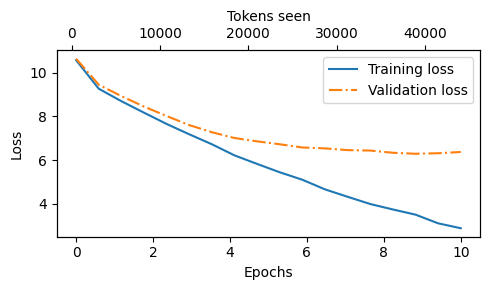

In [36]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

##### Inference:
- The training loss is way lower than the validation loss indicating the model is overfitting.
- This might mostly be due to the small dataset used for training.

## Generating text using various decoding methods:

In [37]:
model.to("cpu")
model.eval() #model is made to not utilize dropout and other methods

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [38]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text(
    model = model,
    idx = text_to_token_ids("The whole world is", tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG["context_length"]
)
print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
The whole world is the I was one of the picture--I felt, and he had been in the: "--as, in the I


##### Inference:
- The above cell returns the same generated text every time we run it. The words generated after input text represents the words which has the highest probability. Thus making the process entirely deterministic


We can now try to randomize the process of generating text.

In [39]:
#assuming a fixed small size vocab to experiment
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v:k for k,v in vocab.items()}
print(inverse_vocab)

{0: 'closer', 1: 'every', 2: 'effort', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


In [40]:
#assuming random logits value for the vocab present
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

#probabilities calculation
probas = torch.softmax(next_token_logits, dim=0)
greedy_next_token_id = torch.argmax(probas).item()
multinomial_next_token_id = torch.multinomial(probas, 1).item()
print(f"Next token ID Greedy method: {greedy_next_token_id}")
print(f"Next token ID multinomial: {multinomial_next_token_id}")

Next token ID Greedy method: 3
Next token ID multinomial: 3


- while both the tokens generated are same the catch is that , with multinomial function the sampling of words from the vocab is done in a probabilistic manner i.e not just based on the highest probability.

In [41]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
    for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{inverse_vocab[i]}:{freq}")
print_sampled_tokens(probas)

closer:71
every:2
effort:0
forward:544
inches:2
moves:1
pizza:0
toward:376
you:4


In [42]:
#using temperature scaling to generate
def softmax_temperature(logits,temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

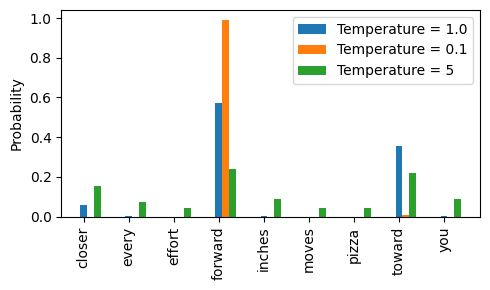

In [43]:
temperatures = [1.,0.1,5]
scaled_probas = [softmax_temperature(next_token_logits,temperature)
                 for temperature in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


In [44]:
print_sampled_tokens(scaled_probas[1])

closer:0
every:0
effort:0
forward:992
inches:0
moves:0
pizza:0
toward:8


In [45]:
print_sampled_tokens(scaled_probas[2])

closer:153
every:68
effort:55
forward:223
inches:102
moves:50
pizza:43
toward:218
you:88


- When the temperature is set to 5, then we can see the model sampling to go haywire compared to when the temperature is set to 0.1 where the effect of torch.argmax leads to more deterministic result of sampling a particular word.

#### Top-k sampling:

The idea is to extend from the previous method , where we were able to generate diverse tokens. However one downside of such a method is the utter nonsense that it can produce. Thus top-k sampling helps in reducing that.
We get to decrease the utter randomness of selecting a particular token by reducing the limit of tokens to be considered for sampling.

In [46]:
top_k = 3
top_logits , top_pos = torch.topk(next_token_logits,top_k)
print(f"Top Logits:{top_logits}")
print(f"Top Positions:{top_pos}")

Top Logits:tensor([6.7500, 6.2800, 4.5100])
Top Positions:tensor([3, 7, 0])


In [47]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [48]:
topk_probas = torch.softmax(new_logits,dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [20]:
def generate(model,idx,max_new_tokens ,context_size,temperature=0.0,
             top_k= None,eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:] 
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits , _ = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits<min_val,
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,1)
        else:
            idx_next = torch.argmax(logits,dim=-1,keepdim=True)
        if idx_next == eos_id:
            break

        idx = torch.cat((idx,idx_next),dim=-1)
    return idx

In [50]:
torch.manual_seed(42)
token_ids = generate(
    model,
    idx = text_to_token_ids("Every effort moves",tokenizer),
    max_new_tokens=15,
    context_size= GPT_CONFIG["context_length"],
    top_k = 25,
    temperature=1.4
)
print(f"Output:\n{token_ids_to_text(token_ids,tokenizer)}")

Output:
Every effort moves into circulation that, you that the with a a little, so--as


#### Loading and saving the model weights

In [51]:
torch.save(model.state_dict(),"model.pth")

In [52]:
model = GPTModel(GPT_CONFIG)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth",map_location=device,weights_only=True))
model.eval(); #this switches the model to eval model disables dropout layers

In [53]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [54]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

/tmp/ipykernel_6656/1135469871.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_location=device)


#### Loading weights from OpenAI

In [11]:
import os
import urllib.request
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm

2025-01-11 08:12:39.835530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736563359.899910    6151 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736563359.918013    6151 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 08:12:40.069068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def download_load_gpt2(model_size,models_dir):
    allowed_sizes = ("124M","335M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")
    
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        with urllib.request.urlopen(download_url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return True  # Indicate success without re-downloading

            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(download_url)
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                with open(destination, "wb") as file:
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))
            return True

    try:
        if _attempt_download(url):
            return
    except (urllib.error.HTTPError, urllib.error.URLError):
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except urllib.error.HTTPError:
                pass

        # If we reach here, both attempts have failed
        error_message = (
            f"Failed to download from both primary URL ({url})")
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


In [13]:
settings , params = download_load_gpt2(
    model_size="124M",models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [14]:
print(f"Settings:{settings}")
print(f"Params explore:{params.keys()}")

Settings:{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Params explore:dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [15]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


model_name = "gpt2-small (124M)" 
NEW_CONFIG = GPT_CONFIG.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [16]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [18]:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [26]:
torch.manual_seed(42)

token_ids = generate(
    model = gpt,
    idx = text_to_token_ids("What is life all", tokenizer).to(device),
    max_new_tokens = 25,
    context_size = NEW_CONFIG["context_length"],
    top_k = 50,
    temperature= 1.5
)

print("Output text:",token_ids_to_text(token_ids,tokenizer))

Output text: What is life all for you? Well, as the news story had it just some good people from all kinds of "craze up all
